<a href="https://colab.research.google.com/github/KhoiDOO/Practice/blob/main/Time%20Series/1.%20Windowed%20Dataset%20for%20Time%20Series%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.figure(figsize=(25,13))
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
!wget --no-check-certificate 
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv

--2021-10-16 07:40:02--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘daily-min-temperatures.csv’

daily-min-temperatu 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2021-10-16 07:40:03 (5.72 MB/s) - ‘daily-min-temperatures.csv’ saved [67921/67921]



<Figure size 720x432 with 0 Axes>

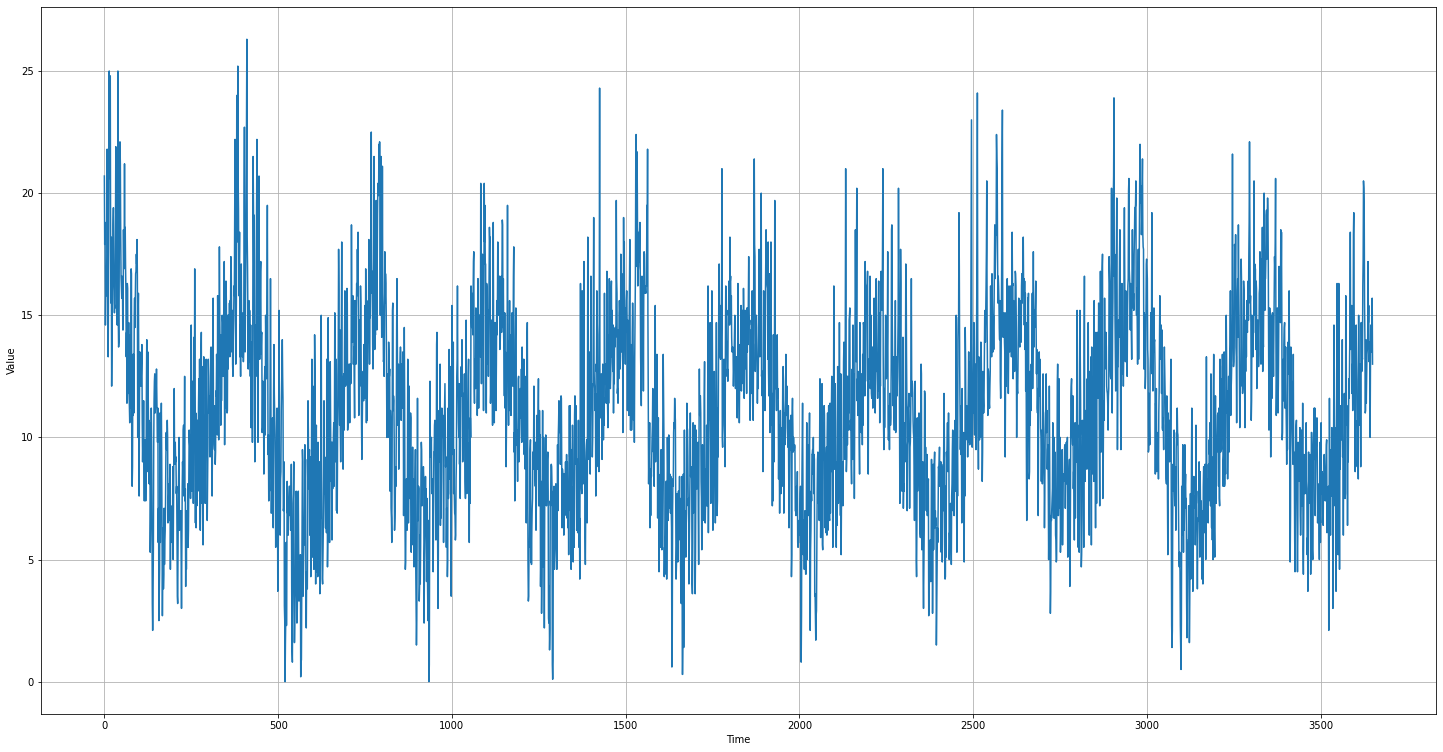

In [ ]:
import csv
time_step = []
temps = []

with open('./daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
split_time = 2500
time_train = time[:split_time] # YOUR CODE HERE
x_train = series[:split_time] # YOUR CODE HERE
time_valid = time[split_time:] # YOUR CODE HERE
x_valid = series[split_time:] # YOUR CODE HERE

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)


In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(512, return_sequences=True),
  tf.keras.layers.LSTM(512, return_sequences=True),
  tf.keras.layers.Dense(1024, activation="relu"),
  tf.keras.layers.Dense(512, activation="relu"),
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 512)         1116160   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 512)         2099200   
_________________________________________________________________
dense (Dense)                (None, None, 1024)        525312    
_________________________________________________________________
dense_1 (Dense)              (None, None, 512)         524800    
_________________________________________________________________
dense_2 (Dense)              (None, None, 128)         65664     
_________________________________________________________________
dense_3 (Dense)              (None, None, 1)           1

In [ ]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 37s 278ms/step - loss: 25.7694 - mae: 26.2693
Epoch 2/100
10/10 [==============================] - 3s 268ms/step - loss: 22.4776 - mae: 22.9772
Epoch 3/100
10/10 [==============================] - 3s 251ms/step - loss: 17.5127 - mae: 18.0102
Epoch 4/100
10/10 [==============================] - 3s 252ms/step - loss: 12.0824 - mae: 12.5728
Epoch 5/100
10/10 [==============================] - 3s 256ms/step - loss: 8.2659 - mae: 8.7535
Epoch 6/100
10/10 [==============================] - 3s 256ms/step - loss: 6.9051 - mae: 7.3942
Epoch 7/100
10/10 [==============================] - 3s 260ms/step - loss: 6.6234 - mae: 7.1110
Epoch 8/100
10/10 [==============================] - 3s 254ms/step - loss: 6.3884 - mae: 6.8761
Epoch 9/100
10/10 [==============================] - 3s 253ms/step - loss: 6.0587 - mae: 6.5439
Epoch 10/100
10/10 [==============================] - 3s 254ms/step - loss: 5.7319 - mae: 6.2164
Epoch 11/100
10/10 [==========

(1e-08, 0.0001, 0.0, 60.0)

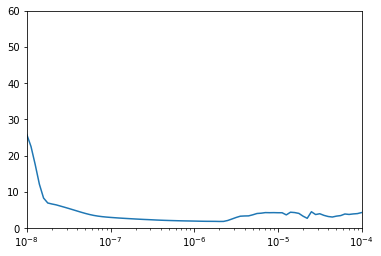

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
second_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(512, return_sequences=True),
  tf.keras.layers.LSTM(512, return_sequences=True),
  tf.keras.layers.Dense(1024, activation="relu"),
  tf.keras.layers.Dense(512, activation="relu"),
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
second_model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
second_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 64)          384       
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 512)         1181696   
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 512)         2099200   
_________________________________________________________________
dense_4 (Dense)              (None, None, 1024)        525312    
_________________________________________________________________
dense_5 (Dense)              (None, None, 512)         524800    
_________________________________________________________________
dense_6 (Dense)              (None, None, 128)         65664     
_________________________________________________________________
dense_7 (Dense)              (None, None, 64)         

In [ ]:
history = second_model.fit(train_set,epochs=150)

Epoch 1/150
10/10 [==============================] - 7s 271ms/step - loss: 16.1872 - mae: 16.6871
Epoch 2/150
10/10 [==============================] - 3s 265ms/step - loss: 13.6264 - mae: 14.1263
Epoch 3/150
10/10 [==============================] - 3s 258ms/step - loss: 10.0795 - mae: 10.5782
Epoch 4/150
10/10 [==============================] - 3s 264ms/step - loss: 6.5415 - mae: 7.0332
Epoch 5/150
10/10 [==============================] - 3s 261ms/step - loss: 4.1762 - mae: 4.6560
Epoch 6/150
10/10 [==============================] - 3s 261ms/step - loss: 3.4164 - mae: 3.8877
Epoch 7/150
10/10 [==============================] - 3s 263ms/step - loss: 3.2959 - mae: 3.7669
Epoch 8/150
10/10 [==============================] - 3s 260ms/step - loss: 3.1684 - mae: 3.6378
Epoch 9/150
10/10 [==============================] - 3s 261ms/step - loss: 3.0230 - mae: 3.4907
Epoch 10/150
10/10 [==============================] - 3s 267ms/step - loss: 2.9159 - mae: 3.3829
Epoch 11/150
10/10 [=============

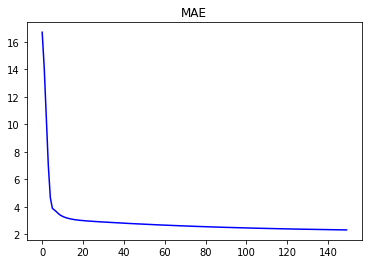

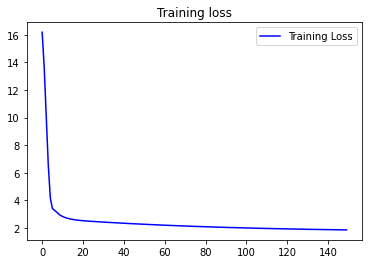

In [ ]:
acc = history.history['mae']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='MAE')
plt.title('MAE')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [ ]:
rnn_forecast = model_forecast(second_model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

<Figure size 720x432 with 0 Axes>

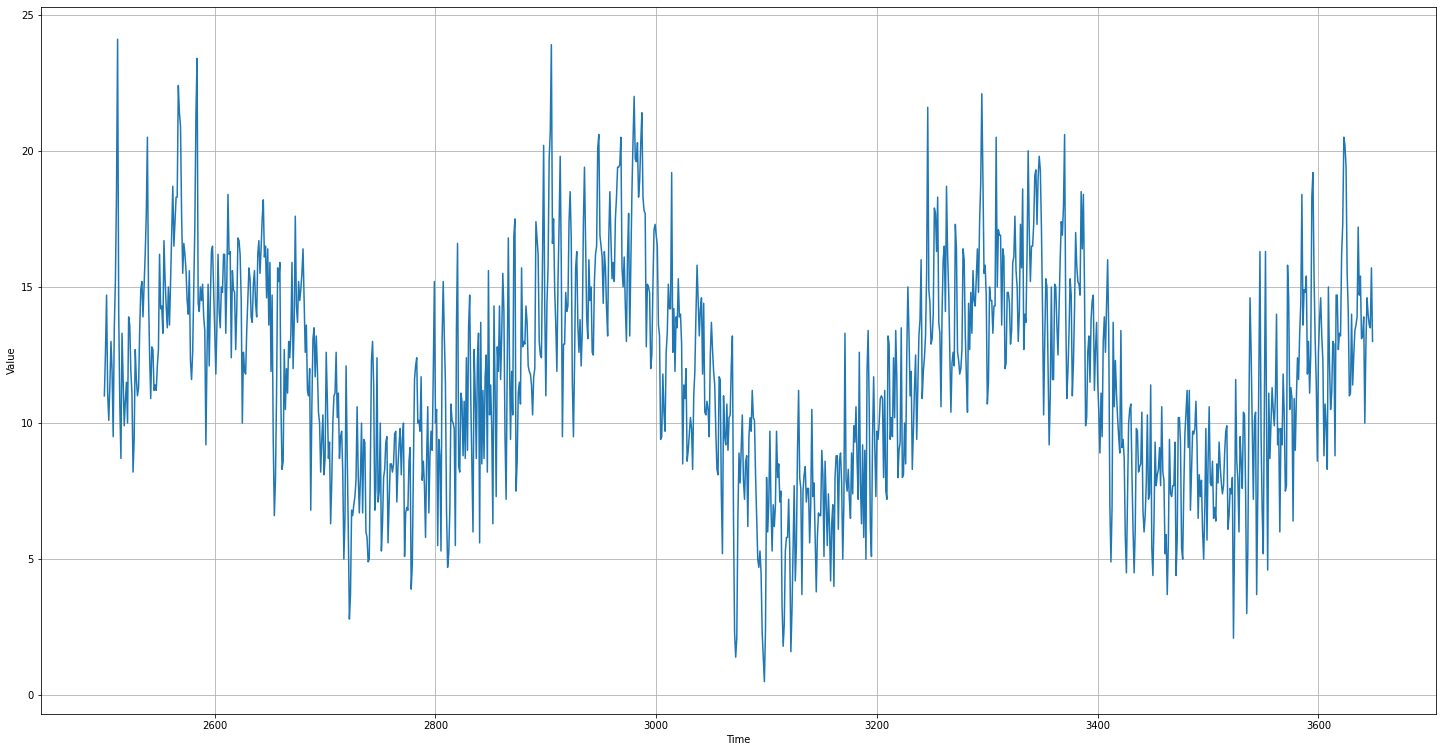

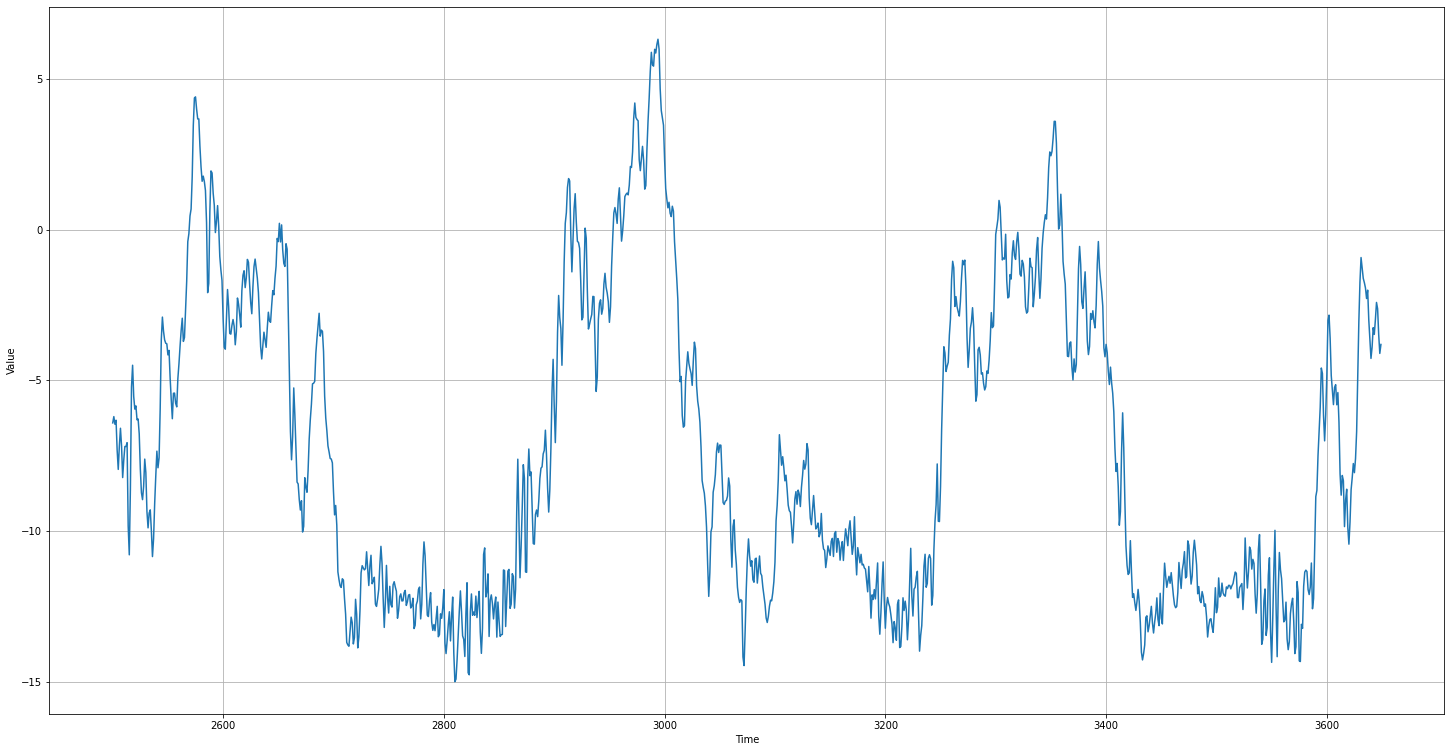

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

18.984522

In [ ]:
print(rnn_forecast)

[-6.410013  -6.201392  -6.454754  ... -3.486385  -4.104126  -3.8066552]
